In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/normal',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Normal',
    r'/kaggle/input/osteoporosis/osteoporosis/normal'
]

osteoporosis_dirs = [
    r'/kaggle/input/osteoporosis-database/Osteoporosis Knee X-ray/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis',
    r'/kaggle/input/osteoporosis-knee-dataset-preprocessed128x256/Osteoporosis Knee Dataset/Osteoporosis',
    r'/kaggle/input/osteoporosis/osteoporosis/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                           filepaths   labels
0  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
1  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
2  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
3  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
4  /kaggle/input/osteoporosis-database/Osteoporos...  Healthy
labels
Osteoporosis    793
Healthy         780
Name: count, dtype: int64


In [4]:
knee_osteoporosis_df.shape

(1573, 2)

In [5]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(1258, 2)
(472, 2)
(315, 2)
(1101, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=4,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=4,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=4,
                                    shuffle=False
                                   )

Found 1258 validated image filenames belonging to 2 classes.
Found 472 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Healthy', 'Osteoporosis']


In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

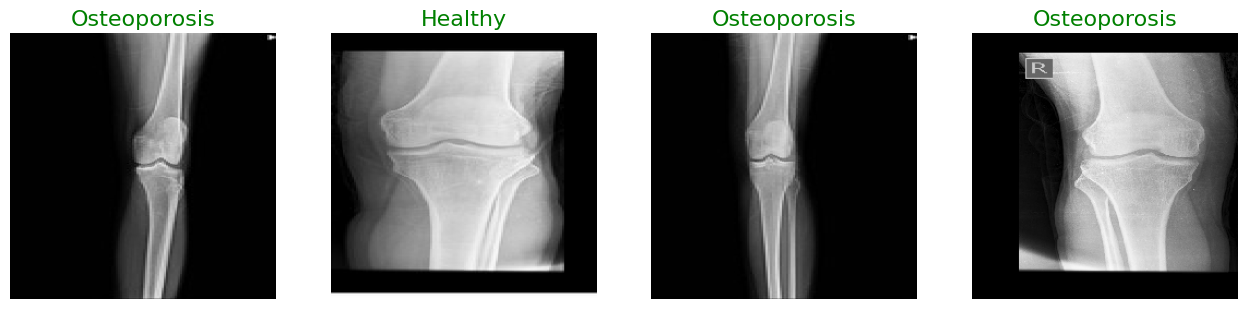

In [10]:
show_knee_images(train)

In [11]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       24704     
                                                                 
 batch_normalization (BatchN  (None, 73, 73, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 256)       819456    
                                                                 
 batch_normalization_1 (Batc  (None, 73, 73, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 256)      0         
 )                                                               
                                                        

In [12]:
history = model.fit(train, epochs=10, validation_data=val, verbose=1)

Epoch 1/10
315/315 [==============================] - 43s 104ms/step - loss: 1.1063 - accuracy: 0.6447 - val_loss: 0.5712 - val_accuracy: 0.7302
Epoch 2/10
315/315 [==============================] - 21s 66ms/step - loss: 0.6410 - accuracy: 0.7273 - val_loss: 0.5719 - val_accuracy: 0.7714
Epoch 3/10
315/315 [==============================] - 21s 65ms/step - loss: 0.5570 - accuracy: 0.7695 - val_loss: 0.4507 - val_accuracy: 0.7905
Epoch 4/10
315/315 [==============================] - 21s 66ms/step - loss: 0.4522 - accuracy: 0.8084 - val_loss: 0.4109 - val_accuracy: 0.8127
Epoch 5/10
315/315 [==============================] - 21s 66ms/step - loss: 0.3850 - accuracy: 0.8323 - val_loss: 0.3918 - val_accuracy: 0.8254
Epoch 6/10
315/315 [==============================] - 21s 65ms/step - loss: 0.3593 - accuracy: 0.8490 - val_loss: 0.3362 - val_accuracy: 0.8444
Epoch 7/10
315/315 [==============================] - 21s 66ms/step - loss: 0.3033 - accuracy: 0.8736 - val_loss: 0.3392 - val_accuracy

In [13]:
history1 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 21s 66ms/step - loss: 0.1559 - accuracy: 0.9444 - val_loss: 0.2133 - val_accuracy: 0.9079
Epoch 2/5
315/315 [==============================] - 21s 66ms/step - loss: 0.1155 - accuracy: 0.9539 - val_loss: 0.2321 - val_accuracy: 0.8952
Epoch 3/5
315/315 [==============================] - 21s 66ms/step - loss: 0.1134 - accuracy: 0.9563 - val_loss: 0.2911 - val_accuracy: 0.8889
Epoch 4/5
315/315 [==============================] - 21s 66ms/step - loss: 0.1167 - accuracy: 0.9603 - val_loss: 0.1861 - val_accuracy: 0.8984
Epoch 5/5
315/315 [==============================] - 21s 65ms/step - loss: 0.0731 - accuracy: 0.9706 - val_loss: 0.2127 - val_accuracy: 0.9175


In [14]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 51ms/step - loss: 0.1849 - accuracy: 0.9258


[0.18487170338630676, 0.9258474707603455]

In [15]:
history2 = model.fit(train, epochs=5, validation_data=val, verbose=1)

Epoch 1/5
315/315 [==============================] - 21s 66ms/step - loss: 0.0746 - accuracy: 0.9714 - val_loss: 0.1641 - val_accuracy: 0.9460
Epoch 2/5
315/315 [==============================] - 21s 65ms/step - loss: 0.0591 - accuracy: 0.9801 - val_loss: 0.1722 - val_accuracy: 0.9270
Epoch 3/5
315/315 [==============================] - 21s 65ms/step - loss: 0.0696 - accuracy: 0.9754 - val_loss: 0.1854 - val_accuracy: 0.9175
Epoch 4/5
315/315 [==============================] - 21s 65ms/step - loss: 0.0674 - accuracy: 0.9762 - val_loss: 0.1863 - val_accuracy: 0.9111
Epoch 5/5
315/315 [==============================] - 21s 65ms/step - loss: 0.0650 - accuracy: 0.9809 - val_loss: 0.2317 - val_accuracy: 0.9143


In [16]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 47ms/step - loss: 0.1944 - accuracy: 0.9301


[0.19436241686344147, 0.930084764957428]

In [17]:
history3 = model.fit(train, epochs=1, validation_data=val, verbose=1)

315/315 [==============================] - 21s 66ms/step - loss: 0.0503 - accuracy: 0.9809 - val_loss: 0.1851 - val_accuracy: 0.9492


In [18]:
model.evaluate(test, verbose=1)

118/118 [==============================] - 6s 49ms/step - loss: 0.1637 - accuracy: 0.9555


[0.163725808262825, 0.9555084705352783]

In [19]:
model.save("Osteoporosis_Model_binary.h5")

In [20]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

118/118 [==============================] - 6s 47ms/step


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

              precision    recall  f1-score   support

     Healthy       0.97      0.94      0.95       231
Osteoporosis       0.94      0.97      0.96       241

    accuracy                           0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472

Accuracy of the Model: 95.6%


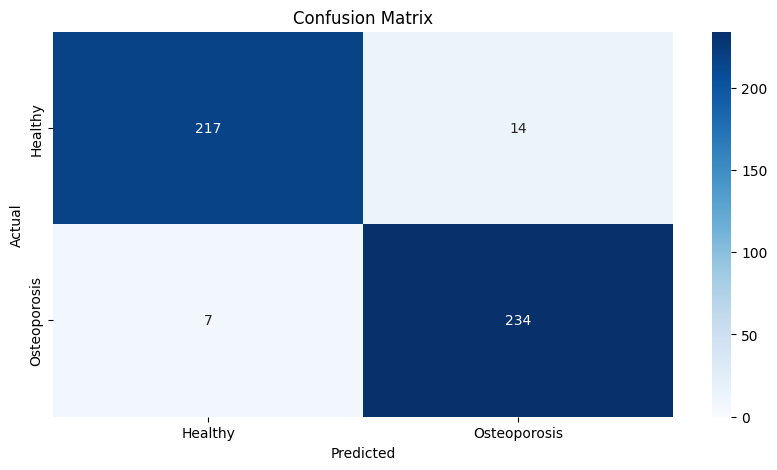

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Healthy','Osteoporosis']

cm = confusion_matrix(y_test, pred2)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

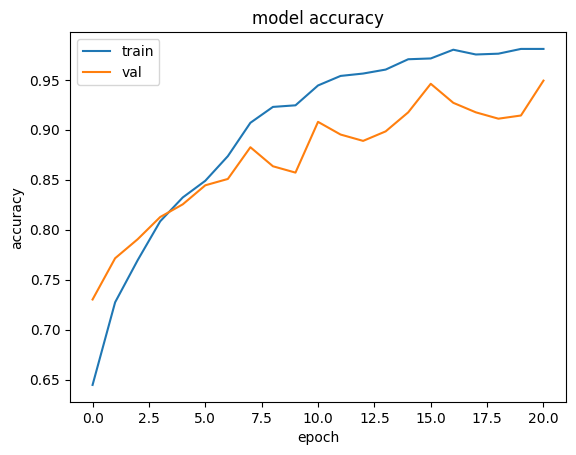

In [23]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

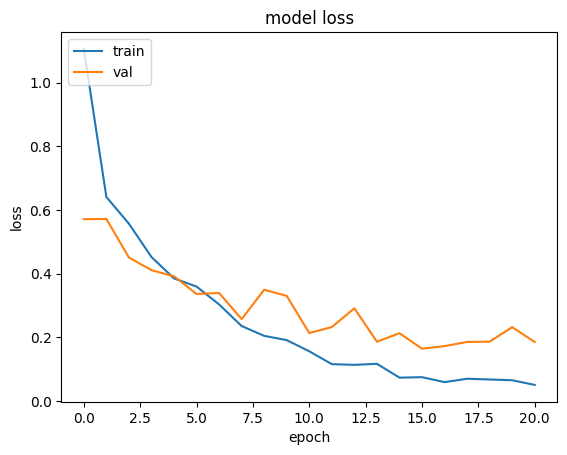

In [24]:
plt.plot(history.history['loss'] + history1.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()